In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy
import psycopg2
from config import postgress_pass
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score

In [2]:
# Conection string for database
engine = create_engine("postgresql+psycopg2://postgres:" + postgress_pass + "@localhost:5432/hotel_bookings_db")
# Reflect the existing database into a new model
Base = automap_base()
# Reflect the tables
Base.prepare(autoload_with=engine)
session = Session(engine)

In [3]:
# Validating database connection
engine.execute('SELECT * FROM hotel_bookings LIMIT 5').fetchall()

[(1, 0, 342, 2015, 7, 27, 1, 0, 0, 2, 0, 0, 0, 136, 3, 1, 0, 0, 0, 2, 2, 0, 3, 0, None, 0, 2, 0.0, 0, 0, 1),
 (1, 0, 737, 2015, 7, 27, 1, 0, 0, 2, 0, 0, 0, 136, 3, 1, 0, 0, 0, 2, 2, 0, 4, 0, None, 0, 2, 0.0, 0, 0, 1),
 (1, 0, 7, 2015, 7, 27, 1, 0, 1, 1, 0, 0, 0, 59, 3, 1, 0, 0, 0, 0, 2, 1, 0, 0, None, 0, 2, 75.0, 0, 0, 0),
 (1, 0, 13, 2015, 7, 27, 1, 0, 1, 1, 0, 0, 0, 59, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 304, 0, 2, 75.0, 0, 0, 0),
 (1, 0, 14, 2015, 7, 27, 1, 0, 2, 2, 0, 0, 0, 59, 6, 3, 0, 0, 0, 0, 0, 0, 0, 0, 240, 0, 2, 98.0, 0, 1, 0)]

In [4]:
# Create data frame from database data
bookings_query = 'SELECT * FROM hotel_bookings'
bookings_df = pd.read_sql_query(bookings_query, engine)
bookings_df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,room_type_fulfilled,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,international
0,1,0,342,2015,7,27,1,0,0,2,...,0,3,0,NaN,0,2,0.0,0,0,1
1,1,0,737,2015,7,27,1,0,0,2,...,0,4,0,NaN,0,2,0.0,0,0,1
2,1,0,7,2015,7,27,1,0,1,1,...,1,0,0,NaN,0,2,75.0,0,0,0
3,1,0,13,2015,7,27,1,0,1,1,...,0,0,0,304.0,0,2,75.0,0,0,0
4,1,0,14,2015,7,27,1,0,2,2,...,0,0,0,240.0,0,2,98.0,0,1,0


In [5]:
# Drop Nulls
bookings_df = bookings_df.dropna(how='any')

In [7]:
# Describe data frame
bookings_df.describe()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,room_type_fulfilled,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,international
count,103050.000000,103050.000000,103050.000000,103050.000000,103050.000000,103050.000000,103050.000000,103050.000000,103050.000000,103050.000000,...,103050.000000,103050.000000,103050.000000,103050.000000,103050.000000,103050.000000,103050.000000,103050.000000,103050.000000,103050.000000
mean,0.309083,0.390044,111.672256,2016.156487,6.594304,27.339427,15.784066,0.977875,2.589355,1.899466,...,0.109413,0.201698,0.122581,86.693382,2.615614,2.116652,104.618808,0.053217,0.605376,0.364803
std,0.462118,0.487762,107.671497,0.706228,3.020402,13.285191,8.793996,1.003935,1.905760,0.491053,...,0.312158,0.624792,0.329375,110.774548,18.783482,0.590669,50.034464,0.225717,0.799216,0.481377
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-6.380000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,26.000000,2016.000000,4.000000,17.000000,8.000000,0.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,9.000000,0.000000,2.000000,72.800000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,79.000000,2016.000000,7.000000,28.000000,16.000000,1.000000,2.000000,2.000000,...,0.000000,0.000000,0.000000,14.000000,0.000000,2.000000,96.300000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,169.000000,2017.000000,9.000000,38.000000,24.000000,2.000000,3.000000,2.000000,...,0.000000,0.000000,0.000000,229.000000,0.000000,2.000000,127.800000,0.000000,1.000000,1.000000
max,1.000000,1.000000,629.000000,2017.000000,12.000000,53.000000,31.000000,16.000000,41.000000,26.000000,...,1.000000,18.000000,2.000000,535.000000,391.000000,3.000000,5400.000000,3.000000,5.000000,1.000000


## Are there more cancellations during specific months?

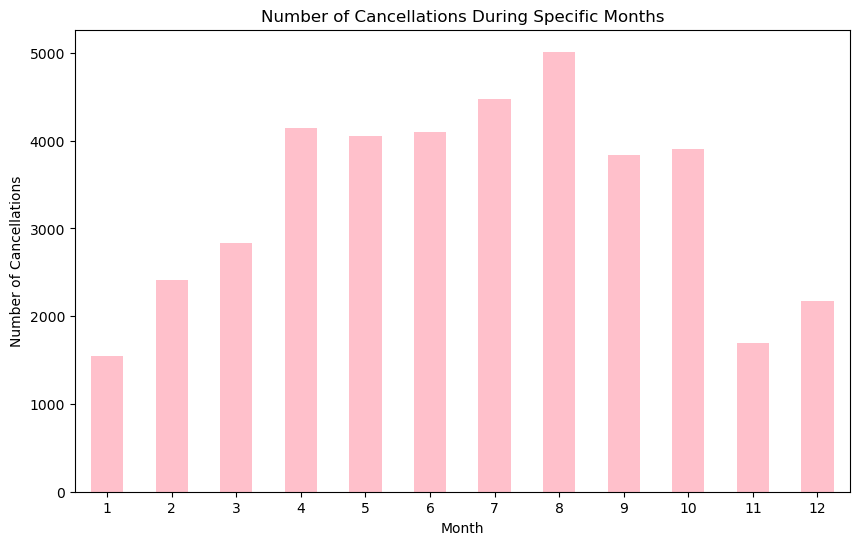

In [8]:
# Group the data by 'arrival_date_month' and count the number of cancellations in each month.
cancellations_by_month = bookings_df[bookings_df['is_canceled'] == 1].groupby('arrival_date_month').size()

# Create a bar plot to visualize the number of cancellations for each month.
plt.figure(figsize=(10, 6))
cancellations_by_month.plot(kind='bar', color='#FFC0CB')
plt.xlabel('Month')
plt.ylabel('Number of Cancellations')
plt.title('Number of Cancellations During Specific Months')
plt.xticks(rotation=0)
plt.show()

## Does customer type contribute to cancellations? 

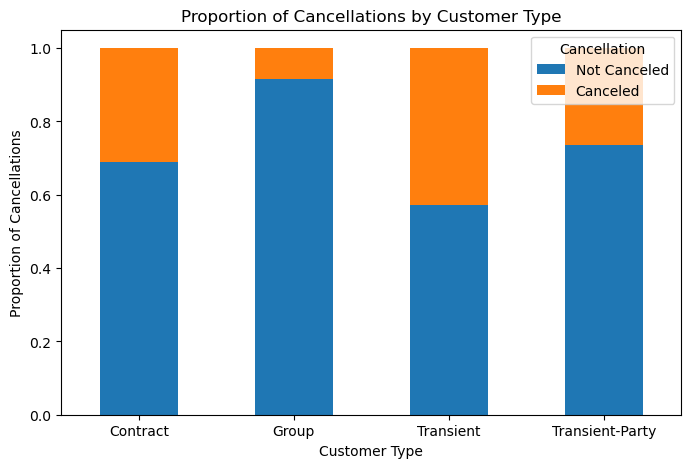

In [9]:
# Create a cross-tabulation between 'customer_type' and 'is_canceled' to get the count of cancellations for each customer type.
customer_type_cancellations = pd.crosstab(bookings_df['customer_type'], bookings_df['is_canceled'])

# Calculate the proportion of cancellations
customer_type_proportions = customer_type_cancellations.div(customer_type_cancellations.sum(axis=1), axis=0)

# Stacked bar plot
customer_type_proportions.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.xlabel('Customer Type')
plt.ylabel('Proportion of Cancellations')
plt.title('Proportion of Cancellations by Customer Type')
plt.legend(title='Cancellation', loc='upper right', labels=['Not Canceled', 'Canceled'])
plt.xticks([0, 1, 2, 3], ['Contract', 'Group', 'Transient', 'Transient-Party'], rotation=0)
plt.show()

## Does a specific country contribute to more or less cancellations?

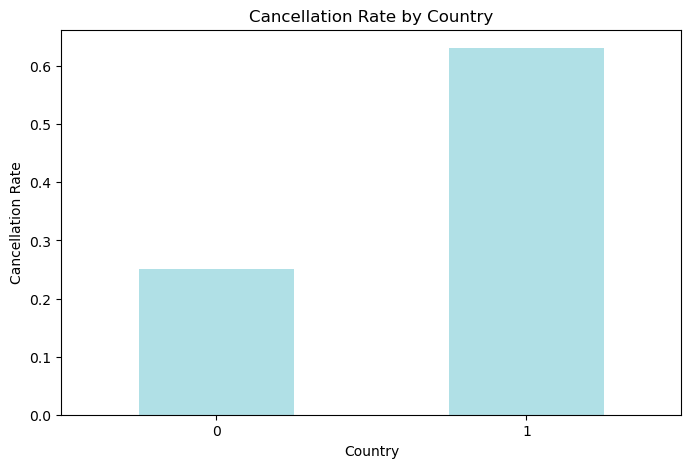

In [10]:
# 0- International, 1- Not international

# Group the data by 'international' and calculate the total number of bookings and cancellations.
country_counts = bookings_df.groupby('international')['is_canceled'].agg(['count', 'sum'])

# Calculate the cancellation rate.
country_counts['cancellation_rate'] = country_counts['sum'] / country_counts['count']

# Bar plot for cancellation rate by country
plt.figure(figsize=(8, 5))
country_counts['cancellation_rate'].plot(kind='bar', color='powderblue')
plt.xlabel('Country')
plt.ylabel('Cancellation Rate')
plt.title('Cancellation Rate by Country')
plt.xticks(rotation=0)
plt.show()

## Do different deposit types affect cancellations?

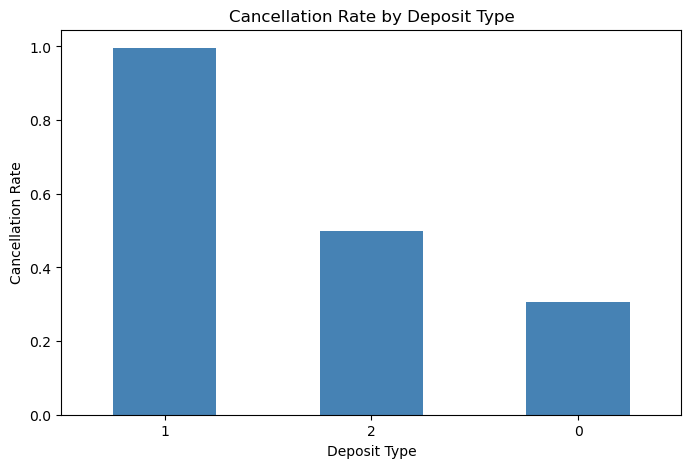

In [11]:
# 0- No Deposit, 1-Non-Refundable, 2-Refundable

# Group the data by 'deposit_type' and calculate the total number of bookings and cancellations for each deposit plan.
deposit_counts = bookings_df.groupby('deposit_type')['is_canceled'].agg(['count', 'sum'])

# Calculate the cancellation rate.
deposit_counts['cancellation_rate'] = deposit_counts['sum'] / deposit_counts['count']

# Sort the data by cancellation rate in descending order to highlight the meal plans with higher cancellation rates.
deposit_counts = deposit_counts.sort_values(by='cancellation_rate', ascending=False)

# Grouped bar plot for cancellation rate by meal plan
plt.figure(figsize=(8, 5))
deposit_counts['cancellation_rate'].plot(kind='bar', color='steelblue')
plt.xlabel('Deposit Type')
plt.ylabel('Cancellation Rate')
plt.title('Cancellation Rate by Deposit Type')
plt.xticks( rotation=0)
plt.show()

## Does lead time affect cancellations?

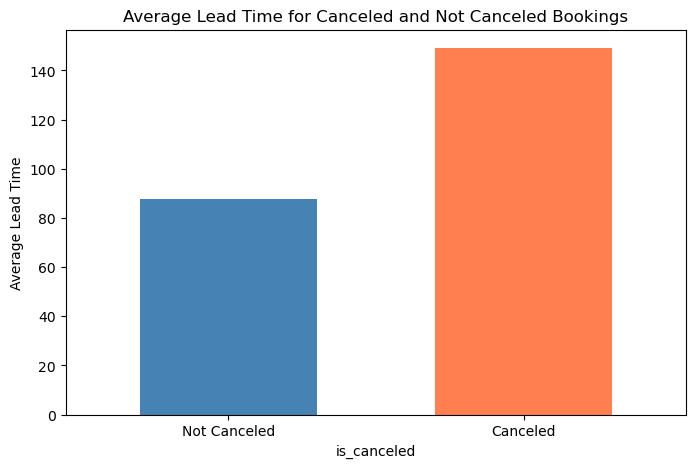

In [12]:
# Calculate the average lead time for 'Canceled' and 'Not Canceled' bookings
average_lead_times = bookings_df.groupby('is_canceled')['lead_time'].mean()

# Bar plot that compares the avrage lead time for 1- is cancelled, and 0- not cancelled bookings
plt.figure(figsize=(8, 5))
average_lead_times.plot(kind='bar', color=['steelblue', 'coral'], width=0.6)
plt.ylabel('Average Lead Time')
plt.title('Average Lead Time for Canceled and Not Canceled Bookings')
plt.xticks([0, 1], ['Not Canceled', 'Canceled'], rotation=0)
plt.show()

## If a reserved room does not match the assigned room, does that lead to cancellations? 

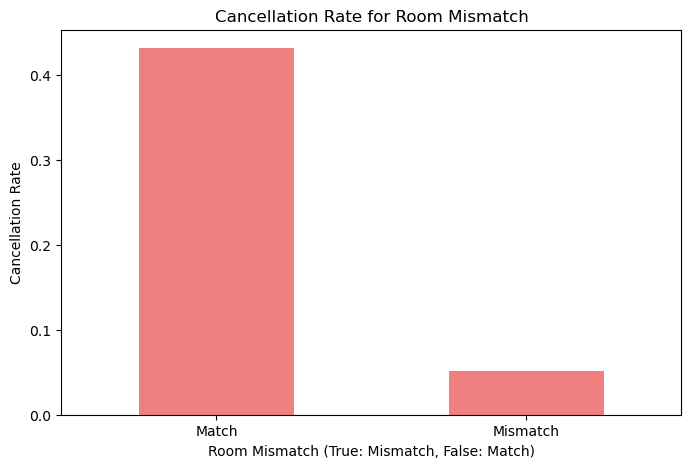

In [13]:
# Create a boolean for bookings where reserved room type is not the same as assigned room type.
room_mismatch = bookings_df['reserved_room_type'] != bookings_df['assigned_room_type']

# Group the data by 'room_mismatch' and calculate the total number of bookings and cancellations for each case.
room_mismatch_counts = bookings_df.groupby(room_mismatch)['is_canceled'].agg(['count', 'sum'])

# Calculate the cancellation rate
room_mismatch_counts['cancellation_rate'] = room_mismatch_counts['sum'] / room_mismatch_counts['count']

# Bar plot
plt.figure(figsize=(8, 5))
room_mismatch_counts['cancellation_rate'].plot(kind='bar', color='lightcoral')
plt.xlabel('Room Mismatch (True: Mismatch, False: Match)')
plt.ylabel('Cancellation Rate')
plt.title('Cancellation Rate for Room Mismatch')
plt.xticks([0, 1], ['Match', 'Mismatch'], rotation=0)
plt.show()

## Does the price range have any impact on the cancellation rates?

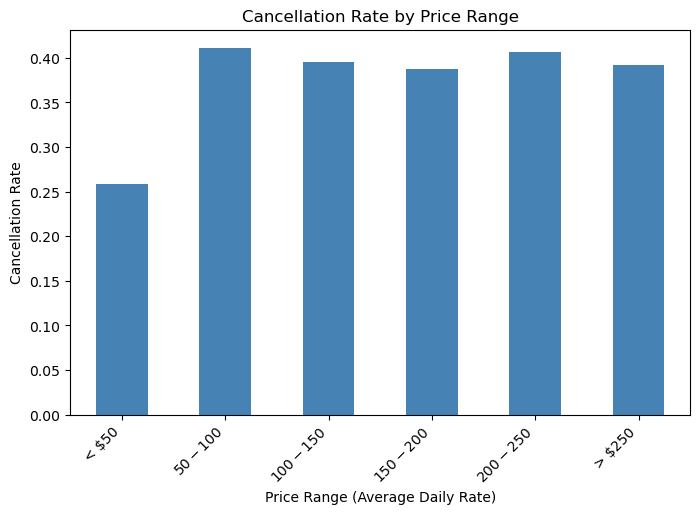

In [14]:
# Calculate the cancellation rate for each price range.
booking_df = bookings_df.copy()
price_ranges = [0, 50, 100, 150, 200, 250, float('inf')]
price_labels = ['< $50', '$50-$100', '$100-$150', '$150-$200', '$200-$250', '> $250']
booking_df['price_range'] = pd.cut(booking_df['adr'], bins=price_ranges, labels=price_labels)
price_counts = booking_df.groupby('price_range')['is_canceled'].agg(['count', 'sum'])
price_counts['cancellation_rate'] = price_counts['sum'] / price_counts['count']
plt.figure(figsize=(8, 5))
price_counts['cancellation_rate'].plot(kind='bar', color='steelblue')
plt.xlabel('Price Range (Average Daily Rate)')
plt.ylabel('Cancellation Rate')
plt.title('Cancellation Rate by Price Range')
plt.xticks(rotation=45, ha='right')
plt.show()

## Stratifying data

In [15]:
# Get value counts of is_canceled column
bookings_df['is_canceled'].value_counts()

0    62856
1    40194
Name: is_canceled, dtype: int64

In [16]:
# Get ratio instead of raw numbers using normalize=True
expected_ratio = bookings_df['is_canceled'].value_counts(normalize=True)

# Round and then convert to percentage
expected_ratio = expected_ratio.round(4)*100

# convert to a DataFrame and store in variable 'is_canceled_ratios'
is_canceled_ratios = pd.DataFrame({'Expected':expected_ratio})
is_canceled_ratios

,Expected
0,61.0
1,39.0


In [17]:
# Stratifying sample
stratified_sample = bookings_df.groupby('is_canceled').apply(
    lambda x: x.sample(frac=1)
)

stratified_sample = stratified_sample.droplevel(0)

stratified_sample.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,room_type_fulfilled,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,international
79740,0,0,9,2015,10,44,31,2,1,2,...,0,0,0,9.0,0,0,87.0,0,1,0
39751,1,0,0,2017,8,34,25,0,2,2,...,0,0,0,241.0,0,2,188.0,0,2,1
37420,1,0,146,2017,6,24,15,0,2,2,...,0,0,0,240.0,0,3,154.0,0,1,0
103406,0,0,7,2016,12,52,18,2,2,2,...,0,0,0,9.0,0,2,90.1,0,2,0
32371,1,0,19,2017,1,3,18,2,5,2,...,0,0,0,8.0,0,2,76.0,0,0,0


In [18]:
# Stratified data info
stratified_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103050 entries, 79740 to 62925
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           103050 non-null  int64  
 1   is_canceled                     103050 non-null  int64  
 2   lead_time                       103050 non-null  int64  
 3   arrival_date_year               103050 non-null  int64  
 4   arrival_date_month              103050 non-null  int64  
 5   arrival_date_week_number        103050 non-null  int64  
 6   arrival_date_day_of_month       103050 non-null  int64  
 7   stays_in_weekend_nights         103050 non-null  int64  
 8   stays_in_week_nights            103050 non-null  int64  
 9   adults                          103050 non-null  int64  
 10  children                        103050 non-null  int64  
 11  babies                          103050 non-null  int64  
 12  meal         

In [19]:
# Ratio of selected items by is_canceled
stratified_ratio = stratified_sample['is_canceled'].value_counts(normalize=True)

# Convert to percentage
stratified_ratio = stratified_ratio.round(4)*100

# We did stratified sampling. So give it proper name
stratified_ratio.name = 'Stratified'

# Proving the stratified ratio matches the whole dataset ratio (is_canceled_ratios)
stratified_ratio.head()

0    61.0
1    39.0
Name: Stratified, dtype: float64

In [20]:
# Separate the features from the target "is_canceled"
y = stratified_sample["is_canceled"]
X = stratified_sample.drop(columns="is_canceled")

In [21]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)

# Logistic Regression

In [22]:
# Creating logistic regression model called "model_lr"
model_lr = LogisticRegression(solver='lbfgs', random_state=1, max_iter=10000,)
model_lr

LogisticRegression(max_iter=10000, random_state=1)

In [23]:
# Train the data
model_lr.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=1)

In [24]:
# Make predictions
predictions_lr = model_lr.predict(X_test)
pd.DataFrame({"Prediction": predictions_lr, "Actual": y_test})

,Prediction,Actual
101798,0,0
55540,0,1
11222,0,1
37359,0,0
80705,0,0
...,...,...
96549,0,0
109875,0,0
88184,0,0
83870,1,0


In [25]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions_lr)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions_lr)

In [26]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions_lr))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,14162,1552
Actual 1,3726,6323


Accuracy Score : 0.7951325544385359
Classification Report
              precision    recall  f1-score   support

           0       0.79      0.90      0.84     15714
           1       0.80      0.63      0.71     10049

    accuracy                           0.80     25763
   macro avg       0.80      0.77      0.77     25763
weighted avg       0.80      0.80      0.79     25763



In [27]:
# Displaying results
lr_acc = accuracy_score(y_test,predictions_lr)
lr_f1 = f1_score(y_test,predictions_lr)
lr_precision = precision_score(y_test,predictions_lr)
lr_recall = recall_score(y_test,predictions_lr)
lr_results = pd.DataFrame([['Logistic regression', lr_acc, lr_f1, lr_precision, lr_recall]],
                     columns =  ['Model','Accuracy Score','F1 score','Precision','Recall'])
lr_results

,Model,Accuracy Score,F1 score,Precision,Recall
0,Logistic regression,0.795133,0.705534,0.802921,0.629217


# Random Forest

In [28]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [29]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [30]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [31]:
# Create a random forest classifier
model_rf = RandomForestClassifier(n_estimators=500, random_state=78)

In [32]:
# Fitting the model
model_rf = model_rf.fit(X_train_scaled, y_train)

In [33]:
# Making predictions using the testing data
predictions_rf = model_rf.predict(X_test_scaled)

In [34]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions_rf)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions_rf)

In [35]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions_rf))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,14548,1166
Actual 1,1588,8461


Accuracy Score : 0.8931025113534914
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.93      0.91     15714
           1       0.88      0.84      0.86     10049

    accuracy                           0.89     25763
   macro avg       0.89      0.88      0.89     25763
weighted avg       0.89      0.89      0.89     25763



In [36]:
# Displaying results
rf_acc = accuracy_score(y_test,predictions_rf)
rf_f1 = f1_score(y_test,predictions_rf)
rf_precision = precision_score(y_test,predictions_rf)
rf_recall = recall_score(y_test,predictions_rf)
rf_results = pd.DataFrame([['Random Forest', rf_acc, rf_f1, rf_precision, rf_recall]],
                     columns =  ['Model','Accuracy Score','F1 score','Precision','Recall'])
rf_results

,Model,Accuracy Score,F1 score,Precision,Recall
0,Random Forest,0.893103,0.860033,0.878882,0.841974


In [37]:
# Random Forests in sklearn will automatically calculate feature importance
importances = model_rf.feature_importances_
# We can sort the features by their importance
sorted(zip(model_rf.feature_importances_, X.columns), reverse=True)

[(0.11677427485218572, 'lead_time'),
 (0.09624785879594805, 'deposit_type'),
 (0.07974558901116295, 'country'),
 (0.0722425782254081, 'adr'),
 (0.06431713224541324, 'agent'),
 (0.06184032903496265, 'total_of_special_requests'),
 (0.05657450030059793, 'international'),
 (0.051811839720693746, 'arrival_date_day_of_month'),
 (0.048242675666488946, 'arrival_date_week_number'),
 (0.040295901552266936, 'market_segment'),
 (0.034441661454901684, 'stays_in_week_nights'),
 (0.03080477145422459, 'previous_cancellations'),
 (0.030122428086360713, 'room_type_fulfilled'),
 (0.027974140075255685, 'arrival_date_month'),
 (0.02616862918149538, 'arrival_date_year'),
 (0.023558909603685844, 'customer_type'),
 (0.02275896409571497, 'required_car_parking_spaces'),
 (0.022269271146039667, 'stays_in_weekend_nights'),
 (0.018048317713758803, 'booking_changes'),
 (0.01741675083268973, 'assigned_room_type'),
 (0.011692768080148516, 'adults'),
 (0.011622105028044071, 'meal'),
 (0.011179243890769842, 'reserved_r

<Axes: title={'center': 'Random Forest Features Importances'}, ylabel='1'>

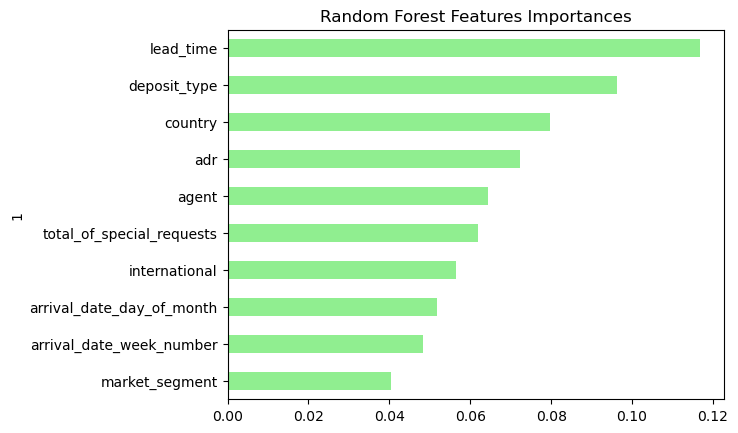

In [38]:
# Visualize the features by importance
rf_importances_df = pd.DataFrame(sorted(zip(model_rf.feature_importances_, X.columns), reverse=True))
rf_importances_df.set_index(rf_importances_df[1], inplace=True)
rf_importances_df.drop(columns=1, inplace=True)
rf_importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
rf_importances_sorted = rf_importances_df[:10].sort_values(by='Feature Importances')
rf_importances_sorted.plot(kind='barh', color='lightgreen', title= 'Random Forest Features Importances', legend=False)

# Decision Tree

In [39]:
# Creating the decision tree classifier instance
model_dt = tree.DecisionTreeClassifier()

In [40]:
# Fitting the model
model_dt = model_dt.fit(X_train_scaled, y_train)

In [41]:
# Making predictions using the testing data
predictions_dt = model_dt.predict(X_test_scaled)

In [42]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions_dt)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions_dt)

In [43]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions_dt))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,13842,1872
Actual 1,1786,8263


Accuracy Score : 0.8580134301129527
Classification Report
              precision    recall  f1-score   support

           0       0.89      0.88      0.88     15714
           1       0.82      0.82      0.82     10049

    accuracy                           0.86     25763
   macro avg       0.85      0.85      0.85     25763
weighted avg       0.86      0.86      0.86     25763



In [44]:
# Displaying results
dt_acc = accuracy_score(y_test,predictions_dt)
dt_f1 = f1_score(y_test,predictions_dt)
dt_precision = precision_score(y_test,predictions_dt)
dt_recall = recall_score(y_test,predictions_dt)
dt_results = pd.DataFrame([['Desicion Tree', dt_acc, dt_f1, dt_precision, dt_recall]],
                     columns =  ['Model','Accuracy Score','F1 score','Precision','Recall'])
dt_results

,Model,Accuracy Score,F1 score,Precision,Recall
0,Desicion Tree,0.858013,0.818767,0.815294,0.822271


In [45]:
# Random Forests in sklearn will automatically calculate feature importance
importances = model_dt.feature_importances_
# We can sort the features by their importance
sorted(zip(model_dt.feature_importances_, X.columns), reverse=True)

[(0.21472917348839046, 'deposit_type'),
 (0.12315988527211719, 'lead_time'),
 (0.07065093834737354, 'international'),
 (0.06677562546248267, 'adr'),
 (0.05419552282982529, 'total_of_special_requests'),
 (0.05024406598978648, 'arrival_date_day_of_month'),
 (0.04991293889812421, 'arrival_date_week_number'),
 (0.047779310064991413, 'agent'),
 (0.03872388531116057, 'country'),
 (0.03700181592323165, 'previous_cancellations'),
 (0.031425648017643665, 'room_type_fulfilled'),
 (0.031147678414201515, 'market_segment'),
 (0.02804542742047779, 'stays_in_week_nights'),
 (0.024300556363700324, 'arrival_date_year'),
 (0.021869185635676264, 'required_car_parking_spaces'),
 (0.01869250261895557, 'stays_in_weekend_nights'),
 (0.01678935351712423, 'customer_type'),
 (0.0148307321409717, 'booking_changes'),
 (0.011595236213230858, 'arrival_date_month'),
 (0.009438187601359525, 'meal'),
 (0.008724121327619596, 'adults'),
 (0.00693598788001307, 'assigned_room_type'),
 (0.006294555483572717, 'reserved_room

<Axes: title={'center': 'Decision Tree Features Importances'}, ylabel='1'>

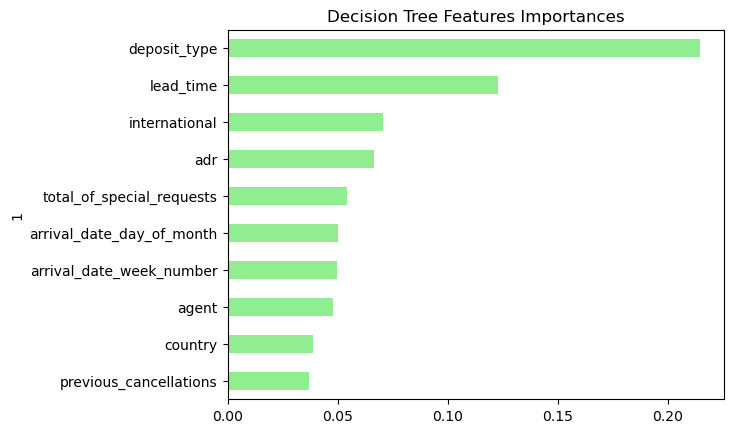

In [46]:
# Visualize the features by importance
dt_importances_df = pd.DataFrame(sorted(zip(model_dt.feature_importances_, X.columns), reverse=True))
dt_importances_df.set_index(dt_importances_df[1], inplace=True)
dt_importances_df.drop(columns=1, inplace=True)
dt_importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
dt_importances_sorted = dt_importances_df[:10].sort_values(by='Feature Importances')
dt_importances_sorted.plot(kind='barh', color='lightgreen', title= 'Decision Tree Features Importances', legend=False)

In [47]:
# Display all results
results = pd.concat([lr_results, rf_results, dt_results])
results_sorted = results.sort_values(by='Accuracy Score', ascending=False).set_index('Model')
results_sorted

,Accuracy Score,F1 score,Precision,Recall
Model,,,,
Random Forest,0.893103,0.860033,0.878882,0.841974
Desicion Tree,0.858013,0.818767,0.815294,0.822271
Logistic regression,0.795133,0.705534,0.802921,0.629217
